In [85]:
from collections import Counter

from pymatgen.io.vasp import Structure, Lattice
from tqdm import tqdm_notebook
import multiprocessing

import numpy as np
import yaml

from polyhedral_analysis.trajectory import Trajectory
from polyhedral_analysis.polyhedra_recipe import PolyhedraRecipe, create_matching_site_generator

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from scipy.stats import gaussian_kde

In [86]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Minion Pro']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams.update({'font.size': 18})
rcParams['mathtext.fontset'] = 'dejavuserif'

In [87]:
with open('../md_runs.yaml') as f:
    md_data = yaml.load(f)
print(md_data)

{'Li6PS5I': {'0p': [1, 2, 3, 4, 5], '50p': [1, 2, 3, 4, 5], '100p': [1, 2, 3, 4]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4], '50p': [1, 2, 3, 4], '100p': [1, 2, 3, 4]}}


In [213]:
# Create reference structures containing ideal 4c and 4a sites in 2x2x2 supercells.

## define a 2x2x2 cell of 4c sites
coords_4c = np.array( [ [ 0.25, 0.25, 0.75 ],
                        [ 0.75, 0.25, 0.25 ],
                        [ 0.25, 0.75, 0.25 ],
                        [ 0.75, 0.75, 0.75 ] ] )
atom_list = [ 'S' ] * len( coords_4c )
lattice = Lattice.from_parameters( a=3.0, b=3.0, c=3.0, alpha=90, beta=90, gamma=90 )
structure = Structure( lattice, atom_list, coords_4c )
reference_structure_4c = structure * [ 2, 2, 2 ]

## define a 2x2x2 cell of 4a sites
coords_4a = np.array( [ [ 0.0, 0.0, 0.0 ],
                        [ 0.5, 0.5, 0.0 ],
                        [ 0.0, 0.5, 0.5 ],
                        [ 0.5, 0.0, 0.5 ] ] )
atom_list = [ 'S' ] * len( coords_4a )
lattice = Lattice.from_parameters( a=3.0, b=3.0, c=3.0, alpha=90, beta=90, gamma=90 )
structure = Structure( lattice, atom_list, coords_4a )
reference_structure_4a = structure * [ 2, 2, 2 ]

reference_structures = { '4c': reference_structure_4c, 
                         '4a': reference_structure_4a }

s_4c_matching_sites = create_matching_site_generator( reference_structure=reference_structure_4c, species=['S'] )
s_4a_matching_sites = create_matching_site_generator( reference_structure=reference_structure_4a, species=['S'] )

In [89]:
def build_poly_recipes(coordination_cutoff, vertex_graph_cutoff):
    poly_recipes = [ PolyhedraRecipe( method='distance cutoff',
                                  coordination_cutoff=coordination_cutoff,  
                                  vertex_graph_cutoff=vertex_graph_cutoff, 
                                  central_atoms=s_4c_matching_sites, 
                                  vertex_atoms=lithium_indices,
                                  label='4c' ),
                     PolyhedraRecipe( method='distance cutoff',
                                  coordination_cutoff=coordination_cutoff,  
                                  vertex_graph_cutoff=vertex_graph_cutoff, 
                                  central_atoms=s_4a_matching_sites, 
                                  vertex_atoms=lithium_indices,
                                  label='4a' ) ]
    return poly_recipes

In [90]:
polyhedral_params = {'Li6PS5I': 
                        {'0p': 
                            {'coordination_cutoff': 2.6,
                             'vertex_graph_cutoff': 4.1 },
                         '50p':
                            {'coordination_cutoff': 2.8,
                             'vertex_graph_cutoff': 4.1 },
                         '100p':
                            {'coordination_cutoff': 2.6,
                             'vertex_graph_cutoff': 4.1 }},
                     'Li6PS5Cl':
                         {'0p': 
                            {'coordination_cutoff': 2.6,
                             'vertex_graph_cutoff': 4.2 },
                         '50p':
                            {'coordination_cutoff': 2.8,
                             'vertex_graph_cutoff': 4.1 },
                         '100p':
                            {'coordination_cutoff': 2.6,
                             'vertex_graph_cutoff': 4.2 }}}
                      
lithium_indices = list(range(192))

In [91]:
ncores = multiprocessing.cpu_count()
data_dir = '../../data'
trajectory_data = {}
for system in md_data:
    trajectory_data[system] = {}
    for disorder, runs in md_data[system].items():
        xdatcars = [ f'{data_dir}/{system}/{disorder}/run{i}/inherent_XDATCAR.gz' for i in runs ]
        print(f'Reading {system}/{disorder} XDATCARs')
        poly_recipes = build_poly_recipes(**polyhedral_params[system][disorder])
        trajectory_data[system][disorder] = Trajectory.from_xdatcars( filenames=xdatcars, 
                                                                      recipes=poly_recipes, 
                                                                      ncores=ncores, 
                                                                      progress='notebook' )

Reading Li6PS5I/0p XDATCARs



Reading Li6PS5I/50p XDATCARs



Reading Li6PS5I/100p XDATCARs



Reading Li6PS5Cl/0p XDATCARs



Reading Li6PS5Cl/50p XDATCARs



Reading Li6PS5Cl/100p XDATCARs


In [92]:
def compute_orientation_angles(trajectory, label):
    angles = []
    for c in trajectory.configurations:
        for p in c.polyhedra_by_label(label):
            angles.extend( p.vertex_vector_orientations() )
    return angles

In [93]:
def generate_gaussian_kde( data, nbins, bw_method ):
    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    x = data[0]
    y = data[1]
    k = gaussian_kde([x,y], bw_method=bw_method)
    xi, yi = np.mgrid[x.min():x.max():nbins[0]*1j, y.min():y.max():nbins[1]*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    return xi, yi, zi

In [94]:
x_res = 300
y_res = 150
orientation_data = {}
for system in trajectory_data:
    orientation_data[system] = {}
    for disorder, trajectory in trajectory_data[system].items():
        orientation_data[system][disorder] = {}
        for label in ['4c', '4a']:
            if label in trajectory.configurations[0].polyhedra_labels:
                print(f'Generating angular kde for {system} {disorder} {label}')
                angles = compute_orientation_angles(trajectory, label)
                xi, yi, zi = generate_gaussian_kde( np.array(angles).T, nbins=[x_res,y_res], bw_method=0.1 )
                orientation_data[system][disorder][label] = (xi, yi, zi)

Generating angular kde for Li6PS5I 0p 4c
Generating angular kde for Li6PS5I 50p 4c
Generating angular kde for Li6PS5I 50p 4a
Generating angular kde for Li6PS5I 100p 4a
Generating angular kde for Li6PS5Cl 0p 4c
Generating angular kde for Li6PS5Cl 50p 4c
Generating angular kde for Li6PS5Cl 50p 4a
Generating angular kde for Li6PS5Cl 100p 4a


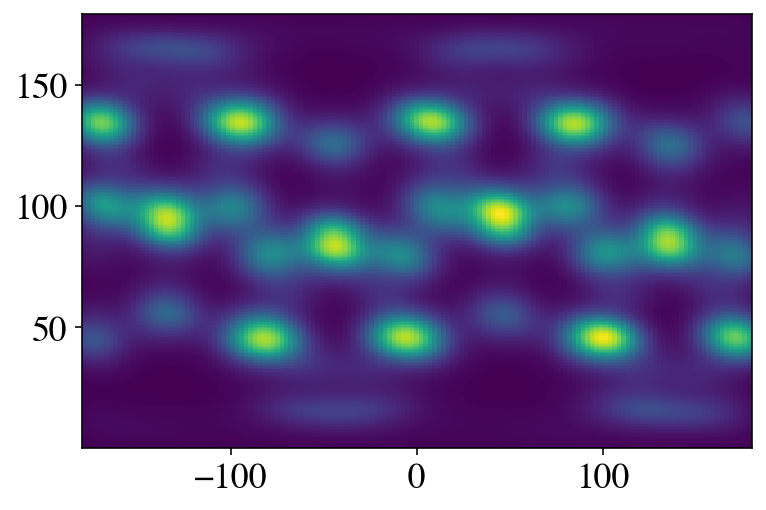

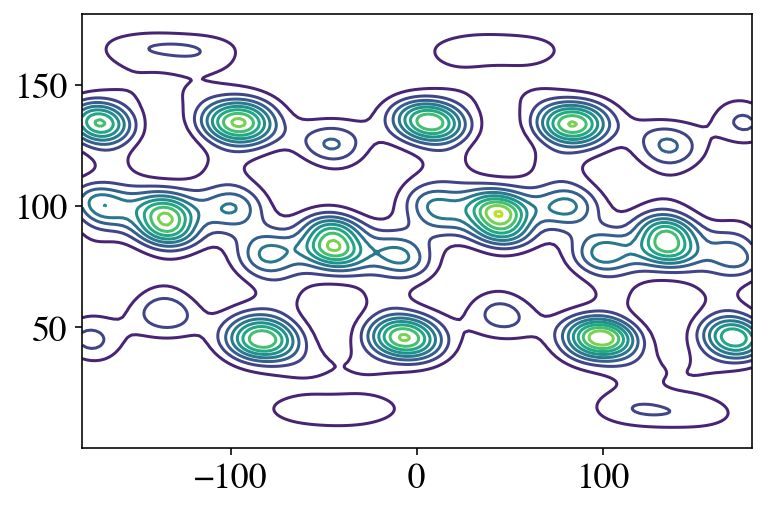

In [95]:
plt.pcolormesh(yi, xi, zi.reshape(xi.shape))
plt.show()
plt.contour(yi, xi, zi.reshape(xi.shape),10)
plt.show()

/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


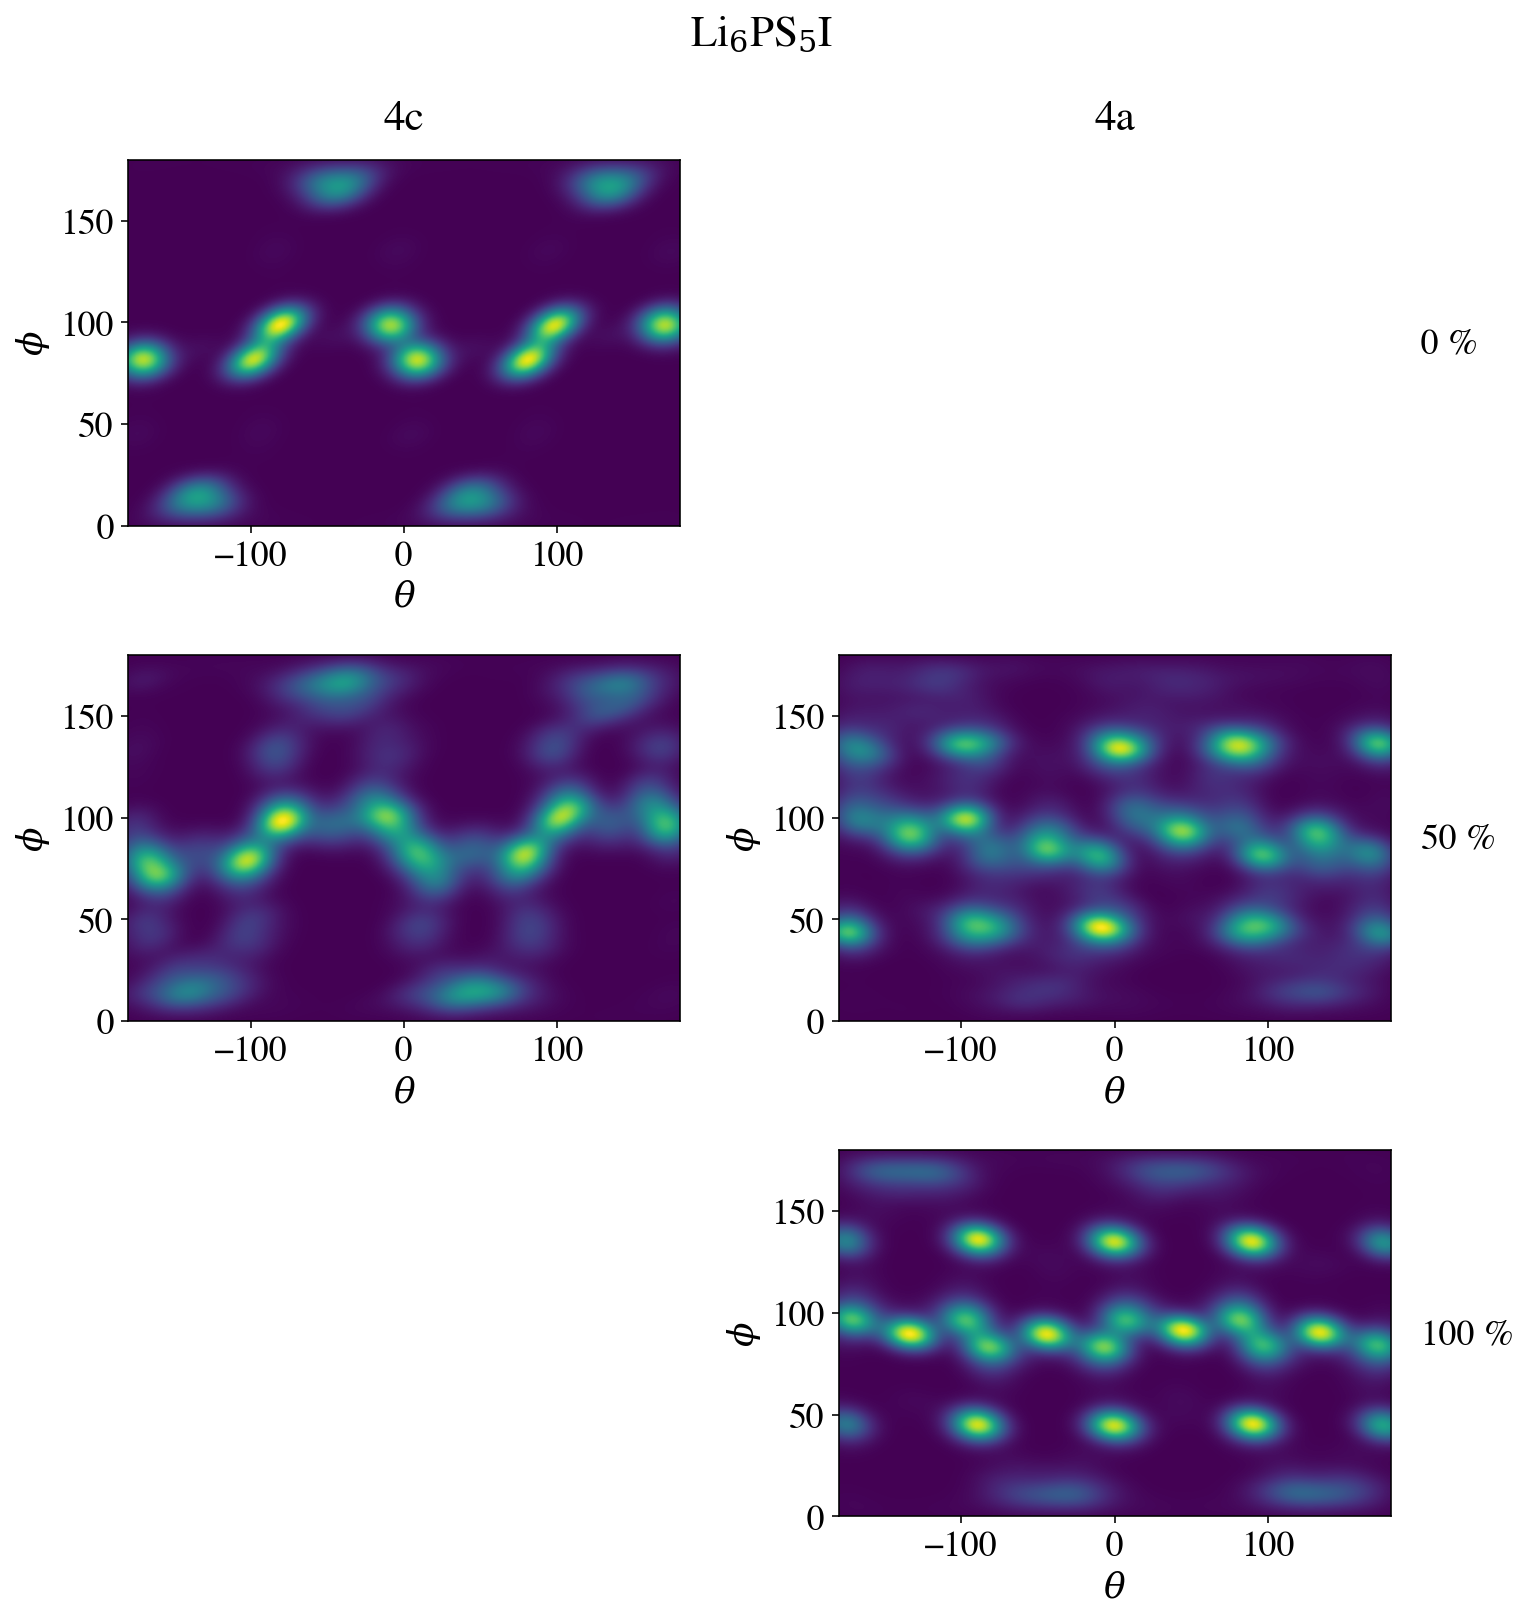

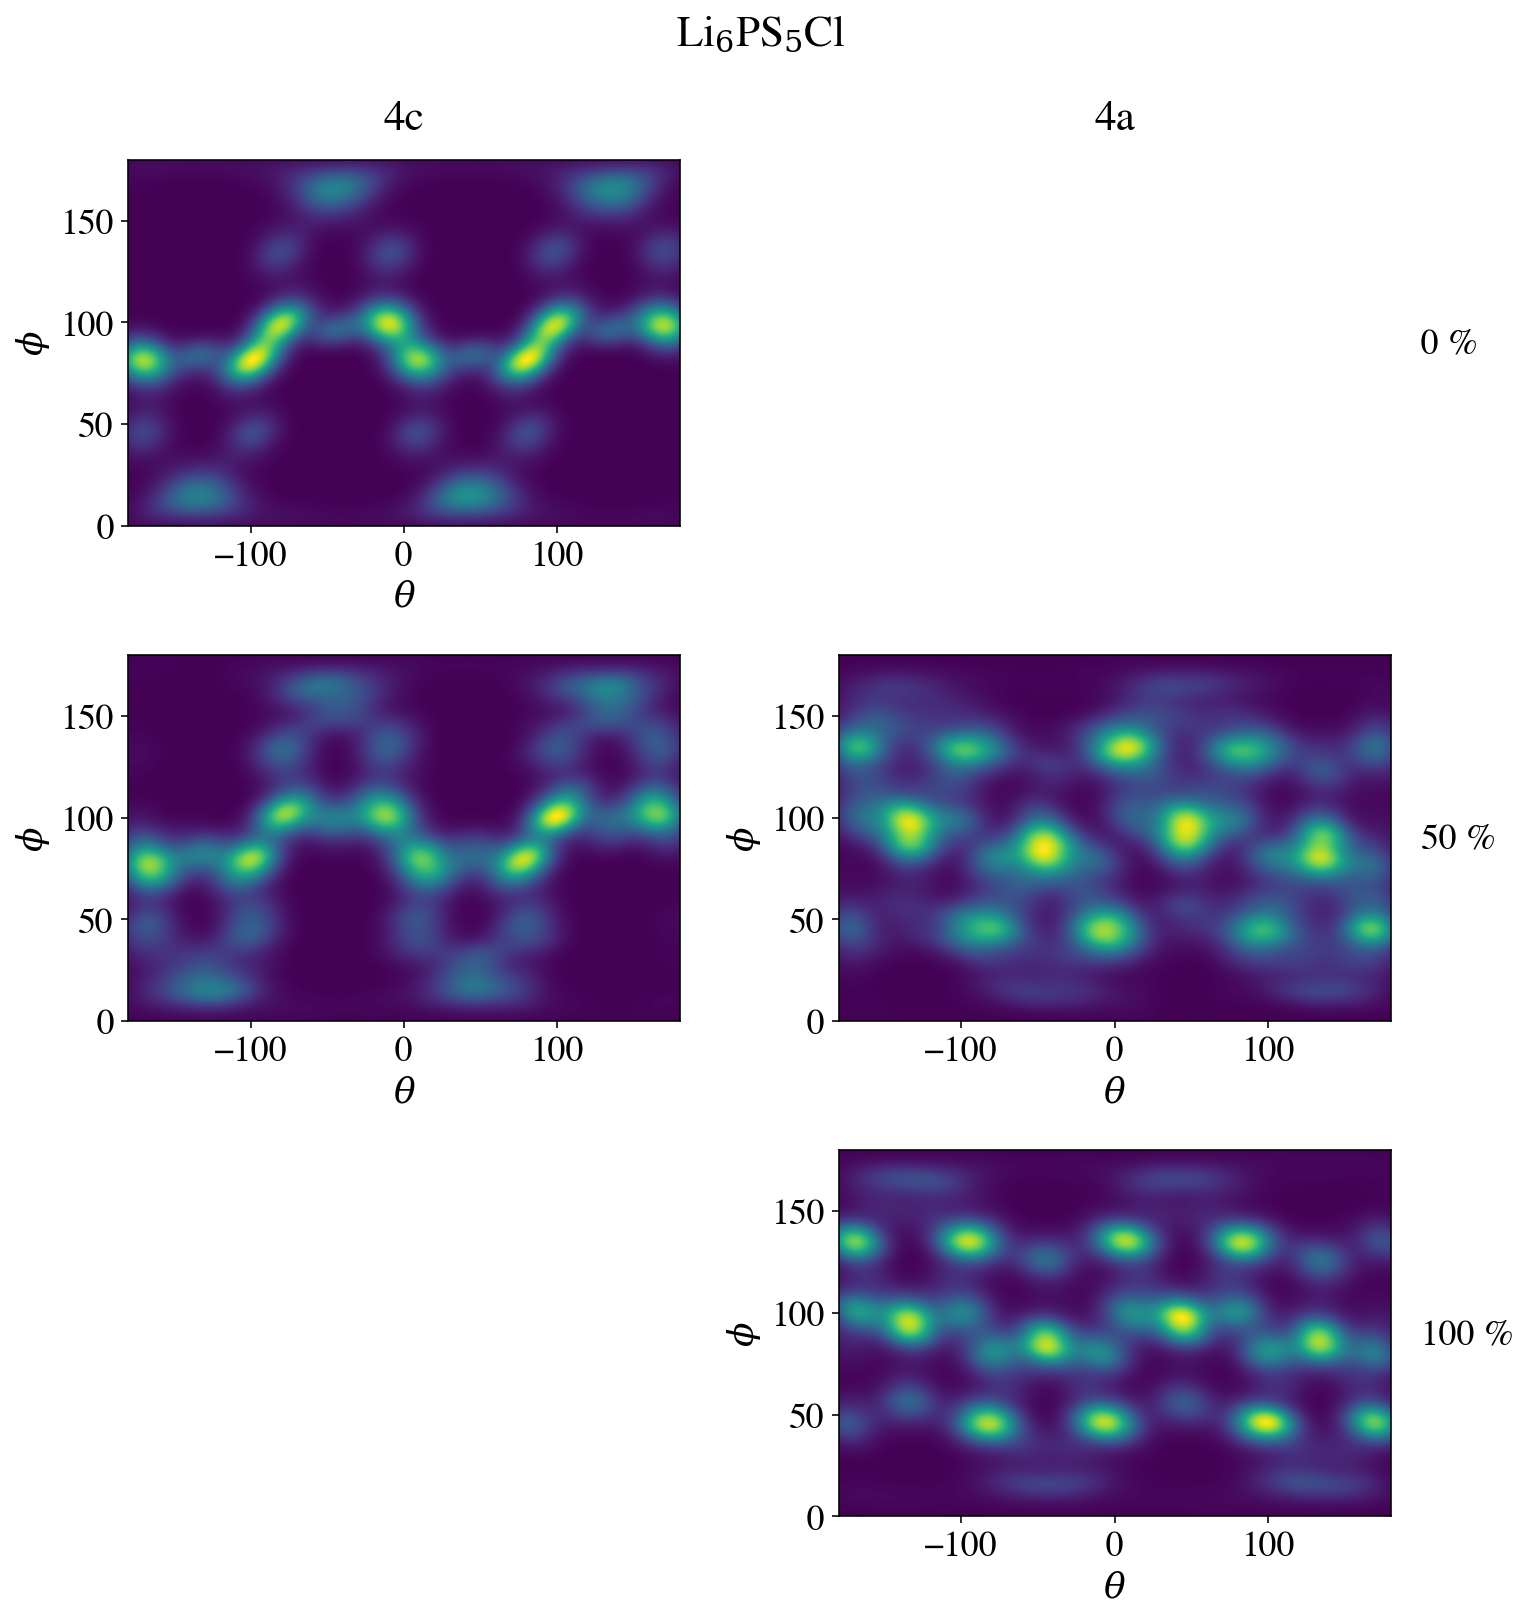

In [97]:
def contour_plot(ax, d):
    x, y, z = d[0], d[1], d[2]
    ax.imshow((z.reshape(x.shape)), interpolation='gaussian', cmap='viridis', aspect='auto',
             extent=[-180, +180, 0, 180], origin='lower', resample=True)
    

for x_spec in ['I', 'Cl']:
    system = f'Li6PS5{x_spec}'
    
    fig, ax = plt.subplots(3,2, figsize=(11,11))

    d = orientation_data[system]['0p']['4c']
    contour_plot(ax[0,0], d)

    d = orientation_data[system]['50p']['4c']
    contour_plot(ax[1,0], d)

    ax[2, 0].axis('off')

    ax[0, 1].axis('off')

    d = orientation_data[system]['50p']['4a']
    contour_plot(ax[1,1], d)

    d = orientation_data[system]['100p']['4a']
    contour_plot(ax[2,1], d)

    for i in range(3):
        for j in range(2):
            ax[i,j].set_xlabel(r'$\theta$')
            ax[i,j].set_ylabel(r'$\phi$')

    ax[0,0].set_title('4c', pad=15)
    ax[0,1].set_title('4a', pad=15)
    ax[0,1].set_xlim([-180, +180])
    ax[0,1].set_ylim([0, +180])
    ax[0,1].text(200,85,'0 %')
    ax[1,1].text(200,85,'50 %')
    ax[2,1].text(200,85,'100 %')

    fig.suptitle(r'Li$_6$PS$_5$' +x_spec, x=0.5, y=1.03)
    fig.tight_layout()
    fig.savefig(f'../../figures/S-Li_orientation_{system}.pdf', bbox_inches='tight')
    fig.show()


/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


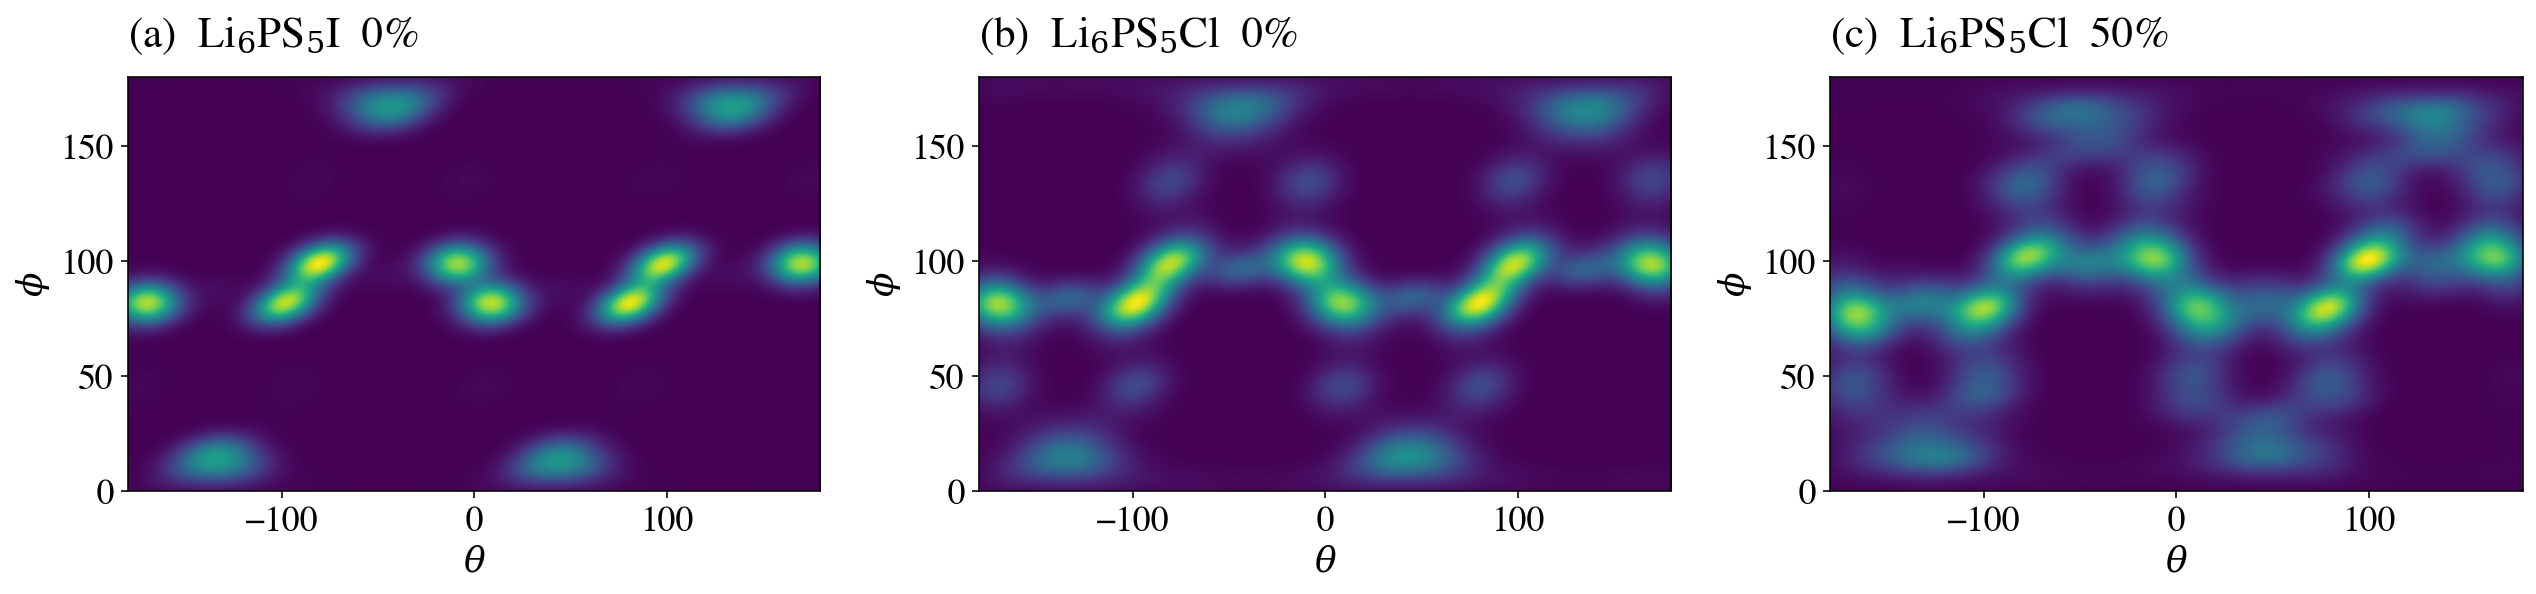

In [98]:
fig, ax = plt.subplots(1,3, figsize=(18,4.5))

d = orientation_data['Li6PS5I']['0p']['4c']
contour_plot(ax[0], d)

d = orientation_data['Li6PS5Cl']['0p']['4c']
contour_plot(ax[1], d)

d = orientation_data['Li6PS5Cl']['50p']['4c']
contour_plot(ax[2], d)


for i in range(3):
    ax[i].set_xlabel(r'$\theta$')
    ax[i].set_ylabel(r'$\phi$')

ax[0].set_title(r'(a)  Li$_6$PS$_5$I  0%', pad=15, loc='left')
ax[1].set_title(r'(b)  Li$_6$PS$_5$Cl  0%', pad=15, loc='left')
ax[2].set_title(r'(c)  Li$_6$PS$_5$Cl  50%', pad=15, loc='left')

fig.tight_layout()
fig.savefig(f'../../figures/S-Li_orientation_examples.pdf', bbox_inches='tight')
fig.show()

In [303]:
# Create reference structures containing ideal 4c and 4a sites in 2x2x2 supercells.

coords_4c = np.array( [ [ 0.25, 0.25, 0.75 ],
                        [ 0.75, 0.25, 0.25 ],
                        [ 0.25, 0.75, 0.25 ],
                        [ 0.75, 0.75, 0.75 ] ] )
atom_list = [ 'S' ] * len( coords_4c )
lattice = Lattice.from_parameters( a=3.0, b=3.0, c=3.0, alpha=90, beta=90, gamma=90 )
structure = Structure( lattice, atom_list, coords_4c )
reference_structure_4c = structure

coords_4a = np.array( [ [ 0.0, 0.0, 0.5 ],
                        [ 0.5, 0.0, 0.0 ],
                        [ 0.0, 0.5, 0.0 ],
                        [ 0.5, 0.5, 0.5 ] ] )
atom_list = [ 'S' ] * len( coords_4a )
lattice = Lattice.from_parameters( a=3.0, b=3.0, c=3.0, alpha=90, beta=90, gamma=90 )
structure = Structure( lattice, atom_list, coords_4a )
reference_structure_4a = structure

reference_structures = { '4c': reference_structure_4c, 
                         '4a': reference_structure_4a }

s_4c_matching_sites = create_matching_site_generator( reference_structure=reference_structure_4c, species=['S'] )
s_4a_matching_sites = create_matching_site_generator( reference_structure=reference_structure_4a, species=['S'] )

In [306]:
from pymatgen.io.vasp import Poscar

In [336]:
poscar = Poscar.from_file('../../data/reference_structures/Li6PS5X_complete_sites.poscar.vasp')
structure = poscar.structure
structure.replace_species({'I': 'S'})
lithium_48h_indices = [ i for i, s in enumerate(structure) if s.species_string is 'Li']
lithium_48i_indices = [ i for i, s in enumerate(structure) if s.species_string is 'Na']
lithium_16j_indices = [ i for i, s in enumerate(structure) if s.species_string is 'Se']

In [337]:
len(lithium_16j_indices)

16

In [338]:
structure

Structure Summary
Lattice
    abc : 10.1413497925 10.1413497925 10.1413497925
 angles : 90.0 90.0 90.0
 volume : 1043.0071548006667
      A : 10.1413497925 0.0 0.0
      B : 0.0 10.1413497925 0.0
      C : 0.0 0.0 10.1413497925
PeriodicSite: S (2.5353, 2.5353, 7.6060) [0.2500, 0.2500, 0.7500]
PeriodicSite: S (7.6060, 7.6060, 7.6060) [0.7500, 0.7500, 0.7500]
PeriodicSite: S (7.6060, 2.5353, 2.5353) [0.7500, 0.2500, 0.2500]
PeriodicSite: S (2.5353, 7.6060, 2.5353) [0.2500, 0.7500, 0.2500]
PeriodicSite: S (0.0000, 0.0000, 5.0707) [0.0000, 0.0000, 0.5000]
PeriodicSite: S (5.0707, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]
PeriodicSite: S (0.0000, 5.0707, 0.0000) [0.0000, 0.5000, 0.0000]
PeriodicSite: S (5.0707, 5.0707, 5.0707) [0.5000, 0.5000, 0.5000]
PeriodicSite: P (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: P (0.0000, 5.0707, 5.0707) [0.0000, 0.5000, 0.5000]
PeriodicSite: P (5.0707, 0.0000, 5.0707) [0.5000, 0.0000, 0.5000]
PeriodicSite: P (5.0707, 5.0707, 0.0000) [0.50

In [339]:
poly_recipes = [ PolyhedraRecipe( method='distance cutoff',
                                  coordination_cutoff=3.0,  
                                  vertex_graph_cutoff=4.1, 
                                  central_atoms=s_4c_matching_sites, 
                                  vertex_atoms=lithium_48h_indices,
                                  label='4c_48h' ),
                     PolyhedraRecipe( method='distance cutoff',
                                  coordination_cutoff=3.0,  
                                  vertex_graph_cutoff=4.1, 
                                  central_atoms=s_4a_matching_sites, 
                                  vertex_atoms=lithium_48i_indices,
                                  label='4a_48i' ),
                     PolyhedraRecipe( method='distance cutoff',
                                  coordination_cutoff=4.0,  
                                  vertex_graph_cutoff=2.6, 
                                  central_atoms=s_4a_matching_sites, 
                                  vertex_atoms=lithium_48h_indices,
                                  label='4a_48h' ),
                     PolyhedraRecipe( method='distance cutoff',
                                  coordination_cutoff=3.0,  
                                  vertex_graph_cutoff=2.6, 
                                  central_atoms=s_4c_matching_sites, 
                                  vertex_atoms=lithium_48i_indices,
                                  label='4c_48i' ),
                      PolyhedraRecipe( method='distance cutoff',
                                  coordination_cutoff=4.0,  
                                  vertex_graph_cutoff=3.0, 
                                  central_atoms=s_4a_matching_sites, 
                                  vertex_atoms=lithium_16j_indices,
                                  label='4a_16j' )]

In [340]:
from polyhedral_analysis.configuration import Configuration
ref_configuration = Configuration( structure=structure,
                                   recipes=poly_recipes)

In [341]:
s_4a_matching_sites(structure)

[4, 5, 6, 7]

In [342]:
o = {}
p = ref_configuration.polyhedra_by_label('4a_48h')[0]
o['4a_48h'] = np.array(p.vertex_vector_orientations())
p = ref_configuration.polyhedra_by_label('4c_48h')[0]
o['4c_48h'] = np.array(p.vertex_vector_orientations())
p = ref_configuration.polyhedra_by_label('4a_48i')[0]
o['4a_48i'] = np.array(p.vertex_vector_orientations())
p = ref_configuration.polyhedra_by_label('4c_48i')[0]
o['4c_48i'] = np.array(p.vertex_vector_orientations())
# p = ref_configuration.polyhedra_by_label('4c_16j')[0]
# o['4c_16j'] = np.array(p.vertex_vector_orientations())
p = ref_configuration.polyhedra_by_label('4a_16j')[0]
o['4a_16j'] = np.array(p.vertex_vector_orientations())

In [343]:
o['4a_16j']

array([[  54.7356145,  135.       ],
       [ 125.2643855,   45.       ],
       [ 125.2643855, -135.       ],
       [  54.7356145,  -45.       ]])

/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


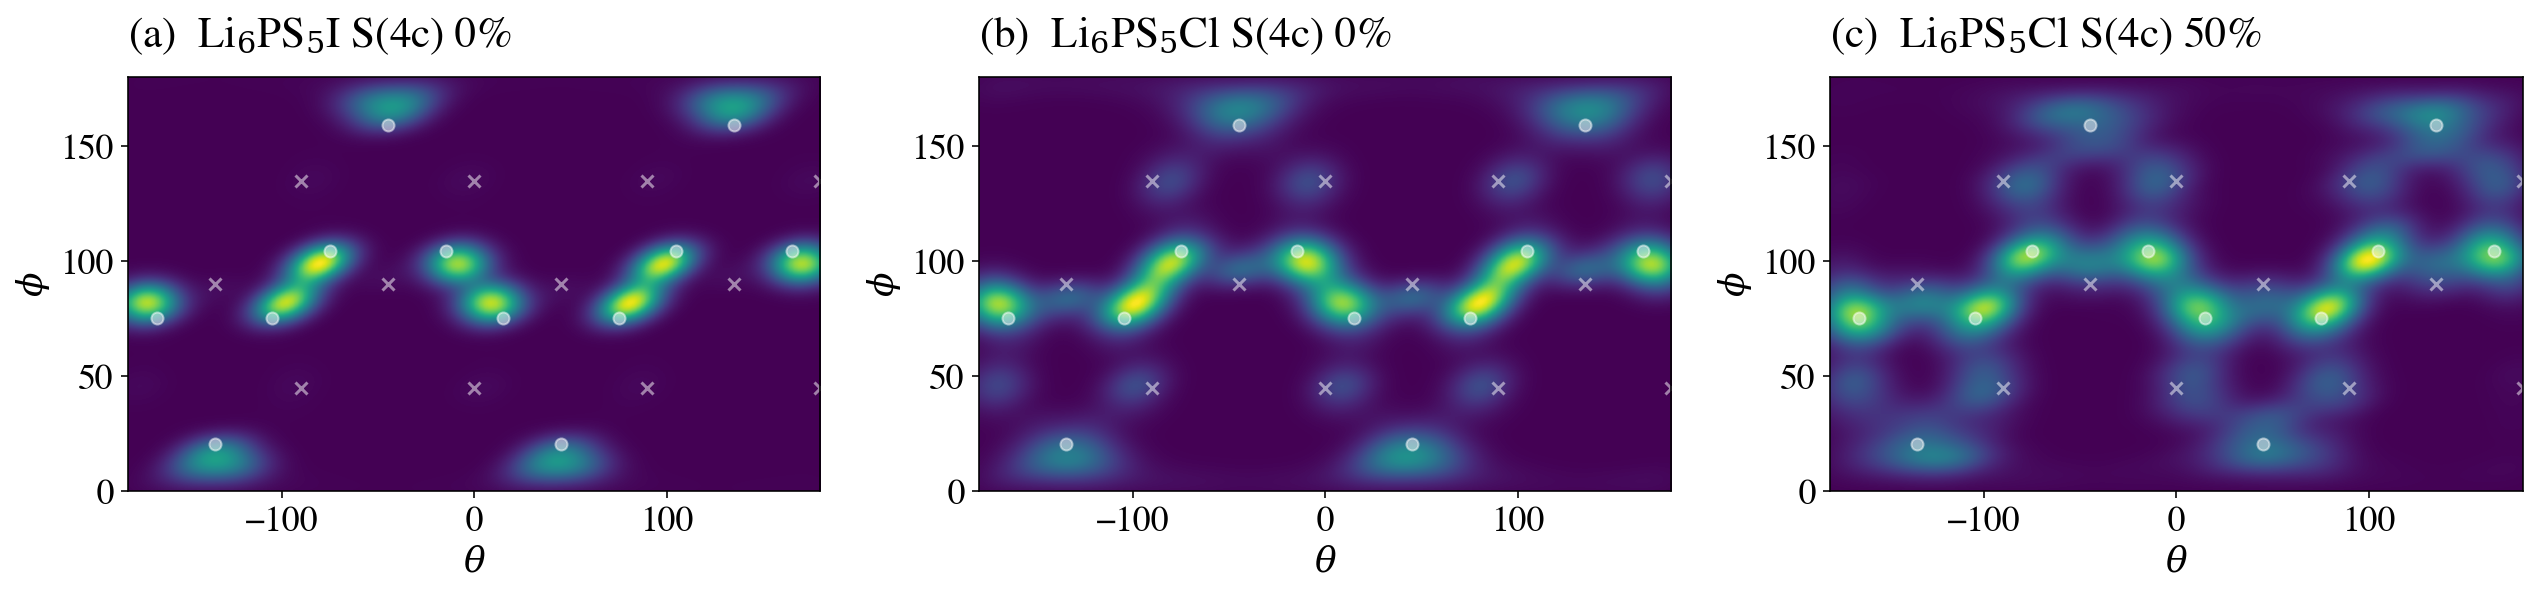

In [354]:
fig, ax = plt.subplots(1,3, figsize=(18,4.5))

d = orientation_data['Li6PS5I']['0p']['4c']
contour_plot(ax[0], d)
ax[0].scatter(-o['4c_48h'][:,1],o['4c_48h'][:,0], c='white', alpha=0.5)
ax[0].scatter(-o['4c_48i'][:,1],o['4c_48i'][:,0], c='white', alpha=0.5, marker='x')
ax[0].scatter(-o['4c_48i'][:,1]+360,o['4c_48i'][:,0], c='white', alpha=0.5, marker='x')


d = orientation_data['Li6PS5Cl']['0p']['4c']
contour_plot(ax[1], d)
ax[1].scatter(-o['4c_48h'][:,1],o['4c_48h'][:,0], c='white', alpha=0.5)
ax[1].scatter(-o['4c_48i'][:,1],o['4c_48i'][:,0], c='white', alpha=0.5, marker='x')
ax[1].scatter(-o['4c_48i'][:,1]+360,o['4c_48i'][:,0], c='white', alpha=0.5, marker='x')

d = orientation_data['Li6PS5Cl']['50p']['4c']
contour_plot(ax[2], d)
ax[2].scatter(-o['4c_48h'][:,1],o['4c_48h'][:,0], c='white', alpha=0.5)
ax[2].scatter(-o['4c_48i'][:,1],o['4c_48i'][:,0], c='white', alpha=0.5, marker='x')
ax[2].scatter(-o['4c_48i'][:,1]+360,o['4c_48i'][:,0], c='white', alpha=0.5, marker='x')


for i in range(3):
    ax[i].set_xlabel(r'$\theta$')
    ax[i].set_ylabel(r'$\phi$')
    ax[i].set_xlim([-180,+180])
ax[0].set_title(r'(a)  Li$_6$PS$_5$I S(4c) 0%', pad=15, loc='left')
ax[1].set_title(r'(b)  Li$_6$PS$_5$Cl S(4c) 0%', pad=15, loc='left')
ax[2].set_title(r'(c)  Li$_6$PS$_5$Cl S(4c) 50%', pad=15, loc='left')

fig.tight_layout()
fig.savefig(f'../../figures/S-Li_orientation_examples_plus_4c.pdf', bbox_inches='tight')
fig.show()

/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


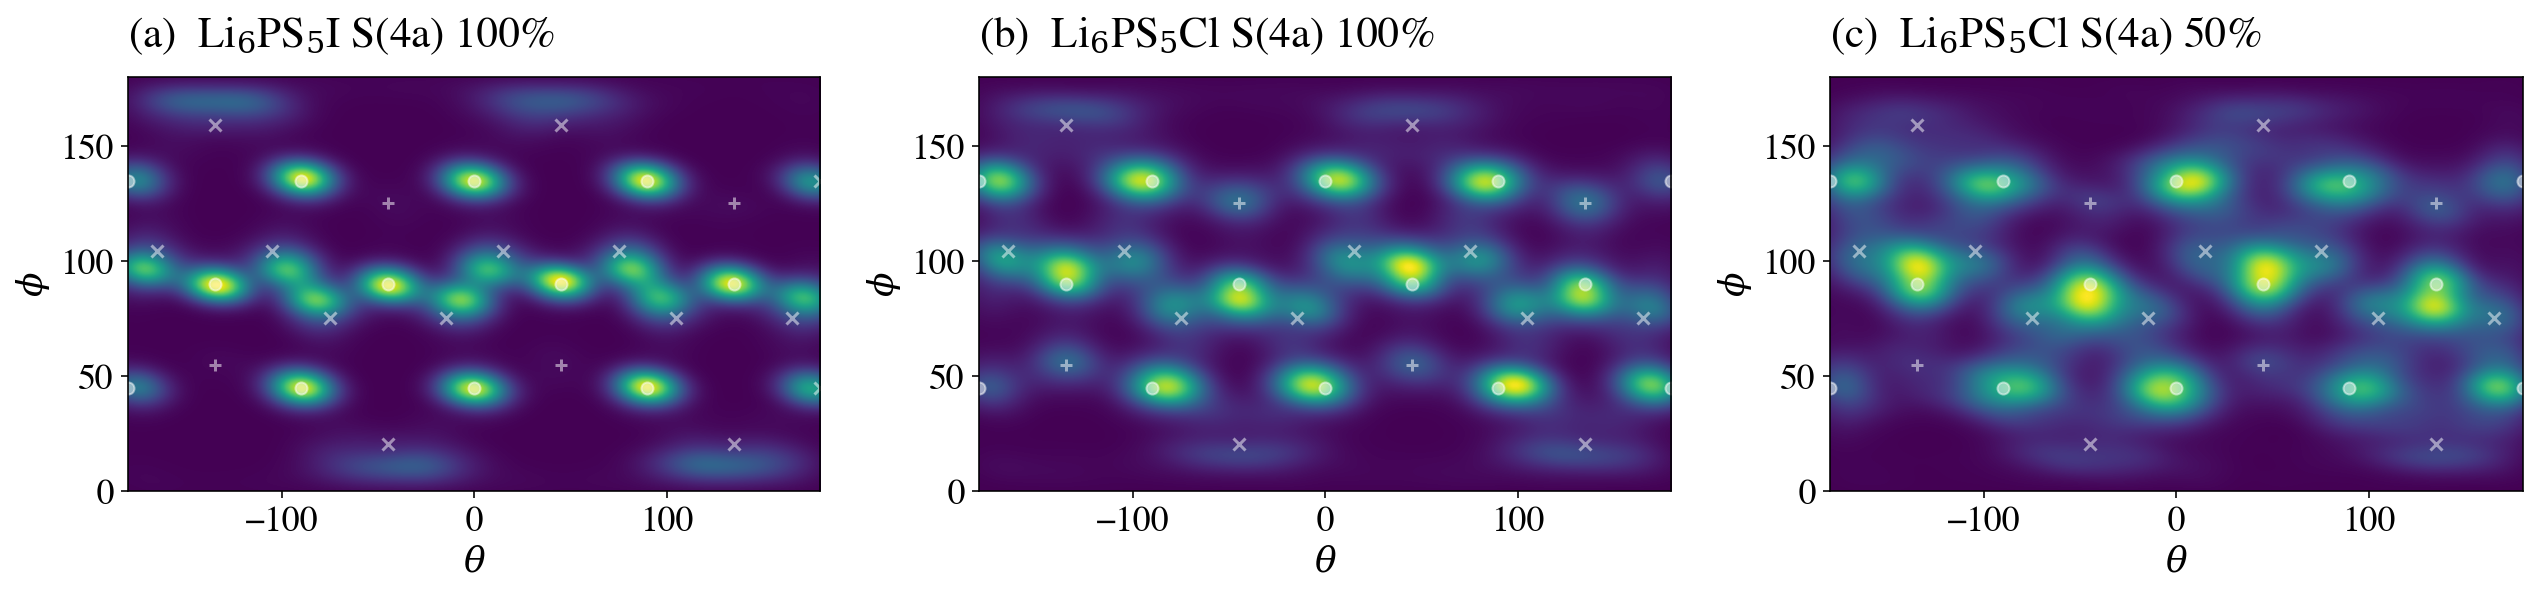

In [355]:
fig, ax = plt.subplots(1,3, figsize=(18,4.5))

d = orientation_data['Li6PS5I']['100p']['4a']
contour_plot(ax[0], d)
ax[0].scatter(-o['4a_48h'][:,1],o['4a_48h'][:,0], c='white', alpha=0.5, marker='o')
ax[0].scatter(-o['4a_48i'][:,1],o['4a_48i'][:,0], c='white', alpha=0.5, marker='x')
ax[0].scatter(-o['4a_16j'][:,1],o['4a_16j'][:,0], c='white', alpha=0.5, marker='+')
ax[0].scatter(-o['4a_48h'][:,1]+360,o['4a_48h'][:,0], c='white', alpha=0.5, marker='x')

d = orientation_data['Li6PS5Cl']['100p']['4a']
contour_plot(ax[1], d)
ax[1].scatter(-o['4a_48h'][:,1],o['4a_48h'][:,0], c='white', alpha=0.5, marker='o')
ax[1].scatter(-o['4a_48i'][:,1],o['4a_48i'][:,0], c='white', alpha=0.5, marker='x')
ax[1].scatter(-o['4a_48h'][:,1]+360,o['4a_48h'][:,0], c='white', alpha=0.5, marker='o')
ax[1].scatter(-o['4a_16j'][:,1],o['4a_16j'][:,0], c='white', alpha=0.5, marker='+')

d = orientation_data['Li6PS5Cl']['50p']['4a']
contour_plot(ax[2], d)
ax[2].scatter(-o['4a_48h'][:,1],o['4a_48h'][:,0], c='white', alpha=0.5, marker='o')
ax[2].scatter(-o['4a_48i'][:,1],o['4a_48i'][:,0], c='white', alpha=0.5, marker='x')
ax[2].scatter(-o['4a_48h'][:,1]+360,o['4a_48h'][:,0], c='white', alpha=0.5, marker='o')
ax[2].scatter(-o['4a_16j'][:,1],o['4a_16j'][:,0], c='white', alpha=0.5, marker='+')


for i in range(3):
    ax[i].set_xlabel(r'$\theta$')
    ax[i].set_ylabel(r'$\phi$')
    ax[i].set_xlim([-180,+180])
ax[0].set_title(r'(a)  Li$_6$PS$_5$I S(4a) 100%', pad=15, loc='left')
ax[1].set_title(r'(b)  Li$_6$PS$_5$Cl S(4a) 100%', pad=15, loc='left')
ax[2].set_title(r'(c)  Li$_6$PS$_5$Cl S(4a) 50%', pad=15, loc='left')

fig.tight_layout()
fig.savefig(f'../../figures/S-Li_orientation_examples_plus_4a.pdf', bbox_inches='tight')
fig.show()

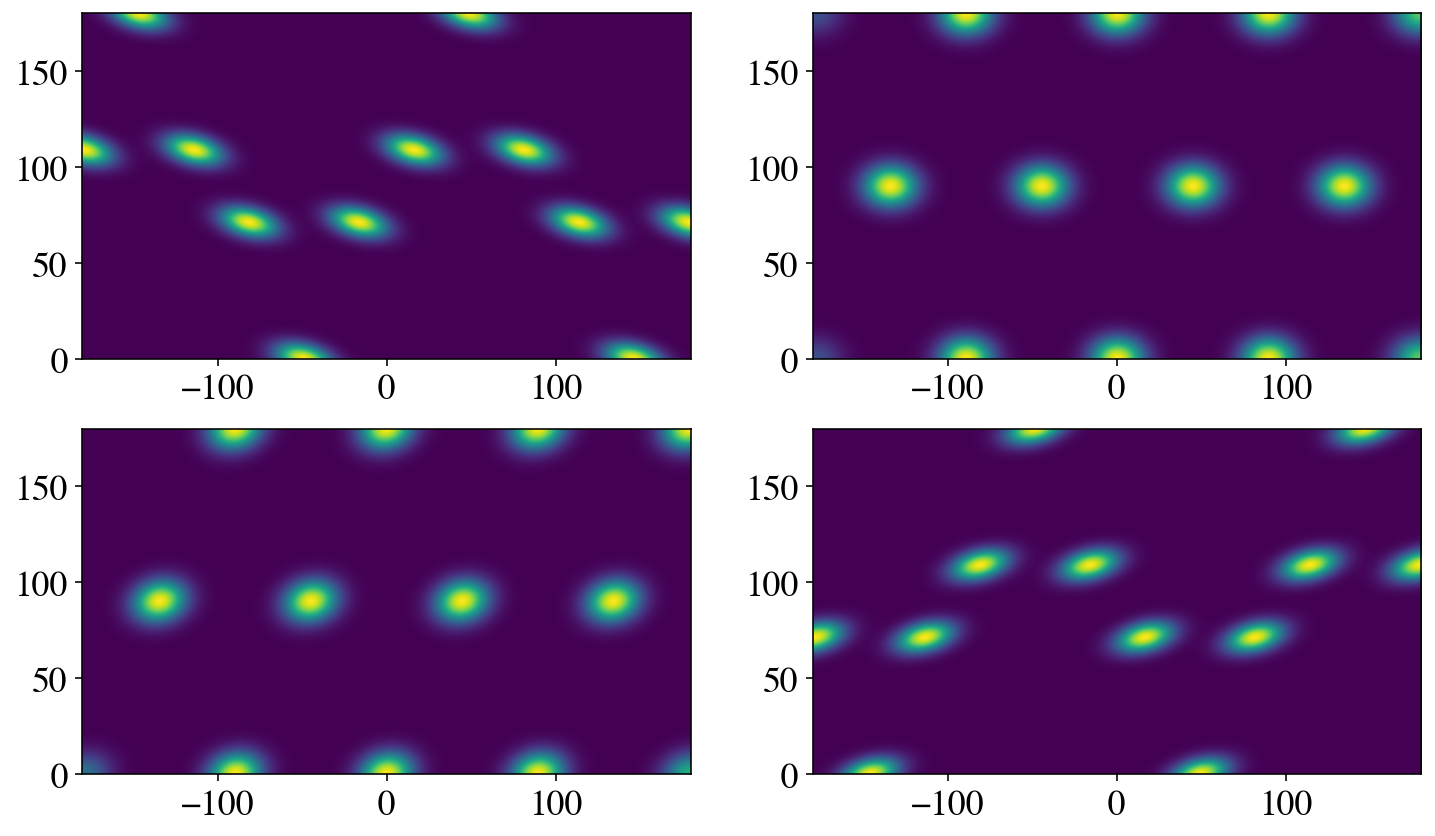

In [76]:
fig, ax = plt.subplots(2,2, figsize=(12,7))
contour_plot(ax[0,0], kde['4c_48h'])
contour_plot(ax[1,0], kde['4c_48i'])
contour_plot(ax[0,1], kde['4a_48h'])
contour_plot(ax[1,1], kde['4a_48i'])

In [77]:
angles['4c_48i']

array([[  45., -180.],
       [  45.,   -0.],
       [ 135.,    0.],
       [ 135.,  180.],
       [  90.,  -45.],
       [  90.,   45.],
       [  90.,  135.],
       [  90., -135.],
       [ 135.,   90.],
       [  45.,   90.],
       [  45.,  -90.],
       [ 135.,  -90.],
       [  45.,  180.],
       [  45.,    0.],
       [ 135.,    0.],
       [ 135.,  180.],
       [  90.,  -45.],
       [  90.,   45.],
       [  90.,  135.],
       [  90., -135.],
       [ 135.,   90.],
       [  45.,   90.],
       [  45.,  -90.],
       [ 135.,  -90.],
       [  45., -180.],
       [  45.,    0.],
       [ 135.,    0.],
       [ 135.,  180.],
       [  90.,  -45.],
       [  90.,   45.],
       [  90.,  135.],
       [  90., -135.],
       [ 135.,   90.],
       [  45.,   90.],
       [  45.,  -90.],
       [ 135.,  -90.],
       [  45.,  180.],
       [  45.,    0.],
       [ 135.,    0.],
       [ 135.,  180.],
       [  90.,  -45.],
       [  90.,   45.],
       [  90.,  135.],
       [  9

In [78]:
o = {}
p = ref_configuration.polyhedra_by_label('4a_48h')[1]
o['4a_48h'] = np.array(p.vertex_vector_orientations())
p = ref_configuration.polyhedra_by_label('4c_48h')[1]
o['4c_48h'] = np.array(p.vertex_vector_orientations())
p = ref_configuration.polyhedra_by_label('4a_48i')[1]
o['4a_48i'] = np.array(p.vertex_vector_orientations())
p = ref_configuration.polyhedra_by_label('4c_48i')[1]
o['4c_48i'] = np.array(p.vertex_vector_orientations())

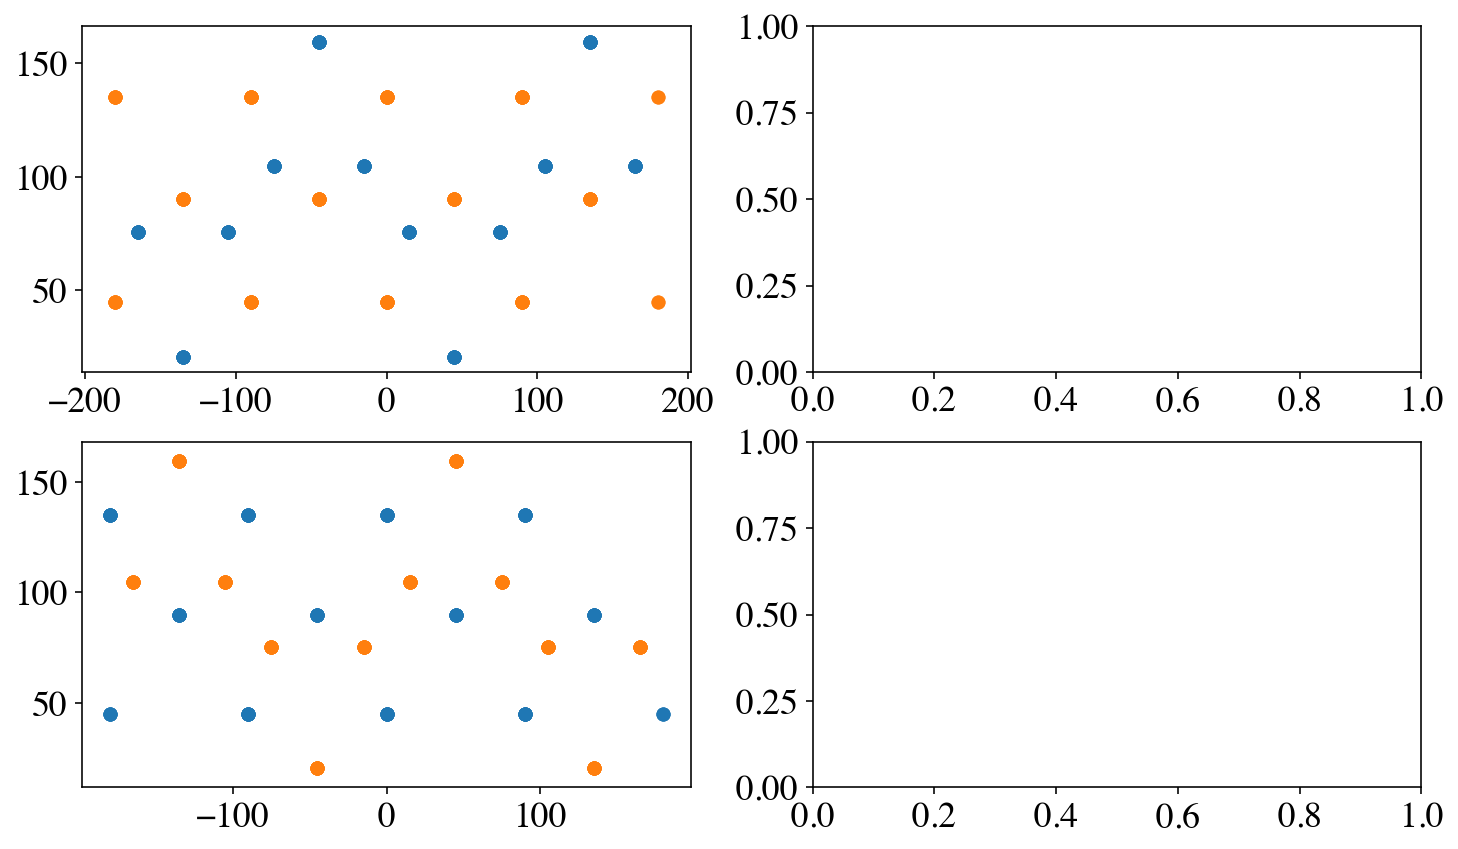

In [84]:
fig, ax = plt.subplots(2,2, figsize=(12,7))
# contour_plot(ax[0,0], kde['4c_48h'])
# contour_plot(ax[1,0], kde['4c_48i'])
# contour_plot(ax[0,1], kde['4a_48h'])
# contour_plot(ax[1,1], kde['4a_48i'])
# ax[0,1].scatter(-o['4c_48h'][:,1],o['4c_48h'][:,0])
# ax[0,1].scatter(-o['4a_48h'][:,1],o['4a_48h'][:,0])
# ax[1,0].scatter(-o['4a_48i'][:,1],o['4a_48i'][:,0])
# ax[1,0].scatter(-o['4c_48i'][:,1],o['4c_48i'][:,0])
ax[0,0].scatter(-angles['4c_48h'][:,1],angles['4c_48h'][:,0])
ax[0,0].scatter(-angles['4a_48h'][:,1],angles['4a_48h'][:,0])
ax[1,0].scatter(-angles['4c_48i'][:,1],angles['4c_48i'][:,0])
ax[1,0].scatter(-angles['4a_48i'][:,1],angles['4a_48i'][:,0])
plt.show()

In [51]:
o['4c_48h']

array([[ 104.51327742,   74.99728398],
       [ 104.51327742, -105.00271602],
       [  75.48672258,  105.00271602],
       [  75.48672258,  -74.99728398],
       [  20.75717083,  135.        ],
       [ 159.24282917, -135.        ],
       [  20.75717083,  -45.        ],
       [ 159.24282917,   45.        ],
       [  75.48672258,  -15.00271602],
       [ 104.51327742, -164.99728398],
       [ 104.51327742,   15.00271602],
       [  75.48672258,  164.99728398]])